<p style="text-align:right;">Mario Stanke, University of Greifswald, Germany</p>

# Solution to Exercise Set 3, Exercise 1 - A <span style="color:red">Convolutional</span> Neural Network to Classify n-Gons

This notebook gives the first example of a *convolutional* neural network for the same data as before: **triangles, quadrilaterals, pentagons and hexagons.**

Step through and run all cells up to **Visualize the Filters** at the end. Follow the instructions there.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import numpy as np
import pickle # to load 'pickled' numpy arrays (serialized, compressed)
from tensorflow.keras.layers import Dense, Flatten
tf.keras.backend.set_floatx('float64')

In [2]:
# load image data as numpy arrays (generated with a separate script available on request)
# Pickling is a way to store datastructures on a drive - or cucumbers in a glass.
# load training data
with open("../data/ngons/ngon_train.pkl", "rb") as f:
    Xtrain, ytrain_class = pickle.load(f)
# load test data
with open("../data/ngons/ngon_test.pkl", "rb") as f:
    Xtest, ytest_class = pickle.load(f)

num_train = Xtrain.shape[0]
num_test = Xtest.shape[0]
height = Xtrain.shape[1]
width = Xtrain.shape[2]
img_size_flat = width * height

num_classes = 4 # 0, 1, 2, 3 for 3-, 4-, 5-, 6-gons

# one-hot encode output classes
ytrain = np.eye(num_classes, dtype=float)[ytrain_class]
ytest = np.eye(num_classes, dtype=float)[ytest_class]
print("Fraction of classes:", np.mean(ytrain, axis=0)) # close to 1/4 each

# normalize input to [0,1]
Xtrain = Xtrain / 255.
Xtest = Xtest / 255.

print("Size of training set is", num_train, ", size of test set is", num_test)

# Number of classes
num_classes = 4 # 0, 1, 2, 3 for 3, ..., 6 gons


Fraction of classes: [0.2567 0.2409 0.2502 0.2522]
Size of training set is 10000 , size of test set is 2000


In [3]:
# Function to plot 8 images in a 2x4 grid, and writing the true and predicted classes below each image.

def plot_images(images, class_true, class_pred=None):
    assert len(images) == len(class_true) == 16

    # Create figure with sub-plots.
    fig, axes = plt.subplots(2, 8)
    fig.subplofigsize=(18, 16)

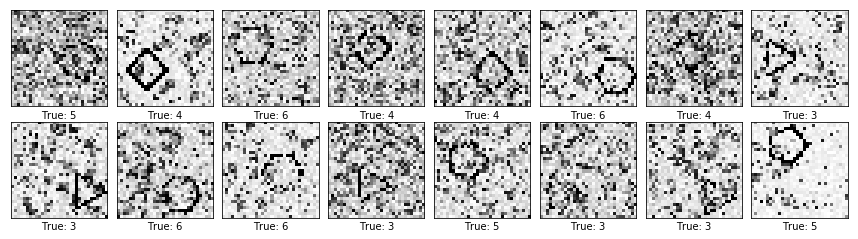

In [4]:
def plot_images(images, class_true, class_pred = None):
    """ Plot 16 (sample) images with their true and predicted classes"""
    assert len(images) == len(class_true) == 16

    # Create figure with sub-plots.
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.05, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], interpolation = 'none', cmap = 'binary') # plot image

        # display also true and predicted classes
        if class_pred is None:
            xlabel = "True: {0}".format(3 + class_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(3 + class_true[i], 3 + class_pred[i])

        ax.set_xlabel(xlabel)

        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])


plot_images(Xtrain[0:16], ytrain_class[0:16])

## Create a Convolutional Neural Network Model


<img src="cnn-ngon.png" alt="cnn architecture" width="800"/>



In [5]:
# Perform the neural network training and report the model, the training history and loss and accuracy on the test set.
   
np.random.seed(1) # so we all get the same pseudorandom results

model = tf.keras.models.Sequential()
model.add( Conv2D(filters = 8, kernel_size = (13, 13), input_shape = (height, width, 1)))
model.add( MaxPooling2D(pool_size = (20, 20)))
model.add( Conv2D(filters = 4, kernel_size = (1, 1),  activation = tf.nn.softmax))
model.add( Flatten())

model.summary()

# define the loss, optimization algorithm and prepare the model for gradient computation 
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# execute the actual training
history = model.fit(np.expand_dims(Xtrain, -1),
                    ytrain, epochs = 20,
                    validation_split = 0.2, verbose = 1,
                    batch_size = 64) # takes ~3 m

W0919 14:14:26.871482 140212458645312 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 8)         1360      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 4)           36        
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
Total params: 1,396
Trainable params: 1,396
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 3s 347us/sample - loss: 1.2190 - accuracy: 0.5144 - val_loss: 0.9415 - val_accuracy: 0.7780
Epoch 2/20
8000/8000 [==============================] - 

In [6]:
test_loss, test_acc  = model.evaluate(np.expand_dims(Xtest, -1), ytest, verbose = 0)
print("Loss on test set:", test_loss, "\nAccuracy on test set:", test_acc)

Loss on test set: 0.03396504664570837 
Accuracy on test set: 0.994


### Plot the training history

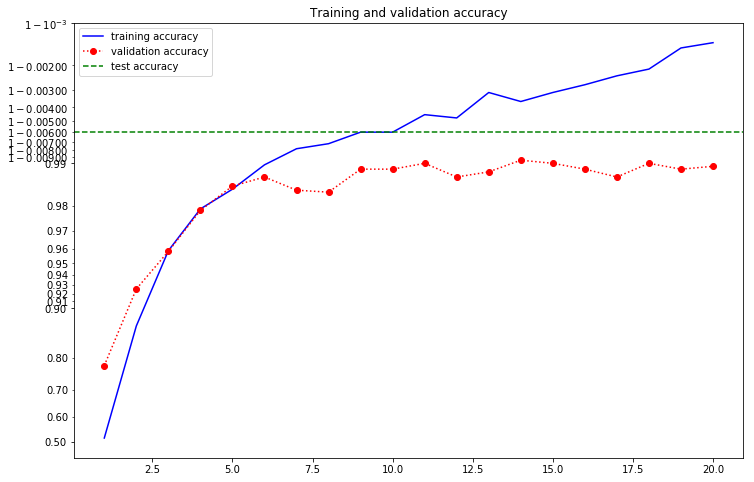

In [7]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.set_title('Training and validation accuracy')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
ax.set_yscale('logit')


ax.plot(epochs, acc, color = "blue", label = "training accuracy")
ax.plot(epochs, val_acc, "o:", color = "red", label = "validation accuracy")
ax.axhline(y = test_acc, color = "green", linestyle = "--", label = "test accuracy")

ax.legend();

From above plot we see that the model classifies training data much better than test date (overfit). It indicates that a model with fewer parameters or regularization could be better.

# Make and Examine Predictions

Predicted class probabilities for 3, 4, 5, 6 for the first 16 images:
 [[0.012 0.981 0.002 0.005]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.001 0.992 0.    0.007]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.001 0.999 0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.004 0.723 0.202 0.071]
 [0.995 0.003 0.001 0.001]]


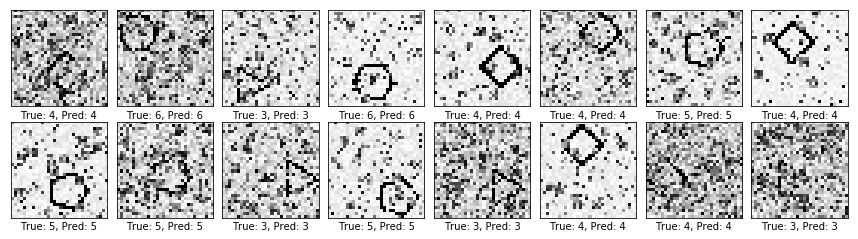

In [8]:
ytest_pred = model(np.expand_dims(Xtest,-1))
print("Predicted class probabilities for 3, 4, 5, 6 for the first 16 images:\n", ytest_pred[0:16].numpy().round(3))

ytest_predclass = np.argmax(ytest_pred, axis = 1)
plot_images(Xtest[0:16], ytest_class[0:16], ytest_predclass[0:16])

# Visualize the Filters
Your task is to create a figure with 8 subplots (axes), one for each filter from the first layer.
Each subplot is a visualization of a $13 \times 13$ array of real numbers. This helps to understand, what patterns the filter respond to, at least in this very simple example.

In [9]:
# obtain the tensor of convolutional filters from the first layer 
Theta0 = model.get_weights()[0]
print(Theta0.shape)
# print the fourth filter as numbers
np.set_printoptions(linewidth = 100)
print(Theta0[:, :, 0, 3].round(3))

(13, 13, 1, 8)
[[-0.017 -0.005  0.021  0.007 -0.09   0.378  0.288 -0.206 -0.088 -0.062 -0.019 -0.044 -0.09 ]
 [ 0.047 -0.155 -0.104 -0.02   0.328  0.235  0.338  0.209 -0.138 -0.067 -0.04   0.03  -0.059]
 [-0.166 -0.269 -0.206  0.328  0.43   0.026 -0.009  0.393  0.21  -0.085 -0.089 -0.072 -0.037]
 [-0.265 -0.166  0.439  0.413 -0.026 -0.055  0.003 -0.003  0.298  0.277 -0.184 -0.032 -0.097]
 [-0.223  0.379  0.423  0.042 -0.054 -0.043 -0.004  0.005  0.001  0.398  0.353 -0.06  -0.026]
 [ 0.271  0.447 -0.026  0.054 -0.075 -0.013 -0.028 -0.031  0.034 -0.019  0.387  0.343 -0.15 ]
 [ 0.35  -0.038 -0.077 -0.001  0.051 -0.03   0.032 -0.003  0.013 -0.082 -0.145  0.163  0.326]
 [ 0.378 -0.039 -0.009  0.028  0.     0.017  0.005 -0.026 -0.037 -0.082 -0.178  0.236  0.454]
 [ 0.33   0.404 -0.057  0.051 -0.005 -0.092 -0.062 -0.023 -0.008 -0.02   0.367  0.359 -0.088]
 [-0.171  0.374  0.445 -0.011 -0.018 -0.028 -0.024 -0.059  0.107  0.347  0.386 -0.08  -0.029]
 [-0.216 -0.252  0.346  0.44  -0.029 -0.035  

Tips: 
 - [plt.imshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html) automatically scales normalizes the pixel numbers to be between 0 and 1 using the minimum and maximum pixel value of the image (i.e. the brightest pixel of each image is always white and the darkest is always black).

In [10]:
# YOUR CODE HERE to create a plot of the filters, ~3 lines
